**[单因子测试: BP ]**

本报告将对因子bp进行单因子分析<br>
pb(市净率)定义为每股市价为每股净资产的倍数，计算方式为：总市值2／最新报告期(资产负债表)归属母公司股东的权益(mkt_cap_ard/equity_mrq)<br>
而bp则定义为pb的倒数，该因子作为一个相对估值法的代表，可以对公司的价值进行衡量

# 数据获取

| Name      | Value           | 
| :------------ |:-------------:|
| 数据库     | MongoDB |
| 用户     | guest     |   
| 密码 | guest      | 
| 连接地址| 192.168.1.105:27017      | 
| 表名 | **sgt_factors_database**      | 


In [1]:
#导入所需模块
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import alphalens
import sys
import warnings
warnings.filterwarnings('ignore')

#
if r'Z:\codebase' not in sys.path:
    sys.path.append(r'Z:\codebase')
from simple_factor.utils import compute_lag_returns, ic_decay_fit, simple_factor_portfolio, compute_neutral_factor
import simple_factor.outlier_process as ops


if r'D:\Dev\pydev\DiyModules' not in sys.path:
    sys.path.append(r'D:\Dev\pydev\DiyModules')
from SGT_MKT.assetlib.sgt_assets import HK_ASSETS
from SGT_MKT.dblib import fetch_sgt_factors

## 选取指定字段数据

**字段包括**：

- Symbol : 股票代码
- TradingDate : 交易日期
- CLOSE : 收盘价
- ADJFACTOR : 复权因子
- PCT_CHG : 当天收益（$PCT\_CHG_t = Ln(AdjClose_{t}) - Ln(AdjClose_{t-1})$）
- PB_MRQ : 市净率
- mkt_cap_ard : 市值2
- industry_hs: 行业

In [2]:
def data_formatter(dataframe):
    df = dataframe.copy(deep= True)
    keys_reflection = {'Symbol': 'asset', 'TradingDate': 'date'}
    target_columns = [keys_reflection.get(name)
                      if name in keys_reflection.keys() else name
                      for name in dataframe.columns]
    df.columns = target_columns
    df.date = pd.to_datetime(df.date, format= '%Y%m%d')
    df = df.set_index(['date', 'asset'])
    return df.squeeze()

factor_name = ['pb_mrq', 'close', 'adjfactor', 'mkt_cap_ard', 'industry_hs']

start = '20100101'
end = None
total_factor = fetch_sgt_factors(None, start_dt= start, end_dt= end, field= factor_name)

total_factor['bp'] = 1/total_factor['PB_MRQ']
total_factor['adjclose'] = total_factor.CLOSE * total_factor.ADJFACTOR

total_factor = data_formatter(total_factor)

total_factor.head().style

ADJFACTOR   CLOSE INDUSTRY_HS   MKT_CAP_ARD    PB_MRQ  \
date       asset                                                            
2010-01-04 0001.HK   1.668776  100.00    综合企业(HS)  2.316164e+11  0.989793   
           3993.HK   1.071095    6.21    原材料业(HS)  3.028102e+10  2.503260   
           0683.HK   1.622654   39.90   地产建筑业(HS)  5.696522e+10  1.186600   
           1988.HK   1.000000    8.87     金融业(HS)  1.974664e+11  3.038958   
           1919.HK   1.252650    9.80      工业(HS)  1.001195e+11  1.969612   

                          bp    adjclose  
date       asset                          
2010-01-04 0001.HK  1.010313  166.877561  
           3993.HK  0.399479    6.651503  
           0683.HK  0.842744   64.743898  
           1988.HK  0.329060    8.870000  
           1919.HK  0.507714   12.275973

## 描述性统计

### 分布情况

count       624842.000000
mean             0.843579
std              0.610459
min             -0.486816
25%              0.397756
50%              0.696982
75%              1.141409
max              6.487718
skew             1.554464
kurtosis         4.028395
Name: bp, dtype: float64


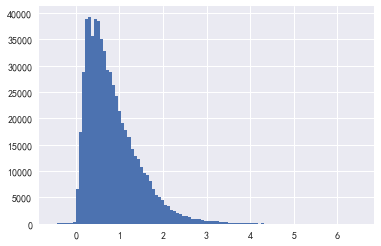

In [10]:
des = total_factor.bp.describe()
des['skew'] = total_factor.bp.skew()
des['kurtosis'] = total_factor.bp.kurtosis()
print(des)

total_factor.bp.hist(bins=100)

### 极值情况

In [11]:
#前10
total_factor.bp.nlargest(10)

date        asset  
2012-01-06  0754.HK    6.487718
2012-01-05  0754.HK    6.365964
2012-01-09  0754.HK    6.281758
2011-10-04  0754.HK    6.272883
2012-01-11  0754.HK    6.183606
2012-01-10  0754.HK    6.151566
2012-01-04  0754.HK    6.119857
2012-01-12  0754.HK    6.104125
2011-10-03  0754.HK    6.094122
2011-10-06  0754.HK    6.031618
Name: bp, dtype: float64

In [13]:
#后10
total_factor.bp.nsmallest(10)

date        asset  
2010-01-04  0008.HK   -0.486816
2010-01-05  0008.HK   -0.476830
2010-01-07  0008.HK   -0.474397
2010-01-06  0008.HK   -0.471989
2010-01-08  0008.HK   -0.464909
2010-01-18  0008.HK   -0.464909
2010-01-13  0008.HK   -0.460306
2010-01-14  0008.HK   -0.460306
2010-01-15  0008.HK   -0.460306
2010-01-11  0008.HK   -0.458038
Name: bp, dtype: float64

### 缺失值情况

count    1823.000000
mean        0.995457
std         0.007853
min         0.953488
25%         0.993884
50%         0.996951
75%         1.000000
max         1.000000
Name: bp, dtype: float64


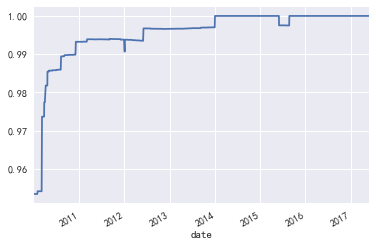

In [14]:
coverage_ratio = total_factor.bp.groupby(level='date').apply(lambda x: 1-x.isnull().sum()/len(x))
print(coverage_ratio.describe())
coverage_ratio.plot()

In [15]:
total_factor.bp[total_factor.bp.isnull()].head()

date        asset  
2010-01-04  0302.HK   NaN
            2332.HK   NaN
            0995.HK   NaN
            0349.HK   NaN
            1071.HK   NaN
Name: bp, dtype: float64

In [16]:
#去缺失值
total_factor = total_factor.dropna(axis=0, subset= ['bp'])

## 数据清洗

### factor data

In [17]:
factor = total_factor['bp']
factor.head()

date        asset  
2010-01-04  0001.HK    1.010313
            3993.HK    0.399479
            0683.HK    0.842744
            1988.HK    0.329060
            1919.HK    0.507714
Name: bp, dtype: float64

### price data

In [18]:
#1
price_frame = pd.read_csv(r'D:\Csv\hk_market\newely_collected\hk_mixed\hk_all_price.csv',
                           encoding= 'gbk')
price_frame = price_frame[price_frame.TRADE_STATUS == '交易']
price_frame = data_formatter(price_frame)
adj_close_extra = (price_frame['CLOSE']*price_frame['ADJFACTOR']).unstack()
adj_close_extra.head()
adj_close = total_factor.adjclose
pricing_est = adj_close.unstack()

#2
pricing = adj_close_extra[pricing_est.columns]
pricing.head()

asset,0001.HK,0002.HK,0003.HK,0004.HK,0005.HK,0006.HK,0008.HK,0010.HK,0011.HK,0012.HK,...,6136.HK,6178.HK,6196.HK,6199.HK,6808.HK,6818.HK,6837.HK,6863.HK,6881.HK,6886.HK
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,166.877561,192.069605,458.081533,99.075269,594.231105,126.632829,9.830979,100.785461,738.275719,126.956635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,169.213847,192.800603,459.480967,102.503096,602.220767,127.525657,10.036864,103.839566,745.399432,129.556430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,169.380724,192.983352,459.014489,103.387697,609.877527,126.930439,10.139806,104.348583,746.694653,127.823233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,169.881357,193.166102,459.947445,101.839646,607.547209,127.376853,10.088335,103.076039,746.694653,125.873387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,170.381990,193.531600,461.346880,100.623320,610.543332,127.674462,10.294219,100.785461,740.866160,128.364857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### size data

In [20]:
mkt_cap = total_factor['MKT_CAP_ARD']
size = pd.np.log(mkt_cap)
size.head()

date        asset  
2010-01-04  0001.HK    26.168349
            3993.HK    24.133787
            0683.HK    24.765707
            1988.HK    26.008834
            1919.HK    25.329630
Name: MKT_CAP_ARD, dtype: float64

### industry data

In [22]:
industry = total_factor['INDUSTRY_HS']
industry.head()

date        asset  
2010-01-04  0001.HK     综合企业(HS)
            3993.HK     原材料业(HS)
            0683.HK    地产建筑业(HS)
            1988.HK      金融业(HS)
            1919.HK       工业(HS)
Name: INDUSTRY_HS, dtype: object

### 因子数据标准化

count    6.221530e+05
mean    -1.356294e-17
std      9.985347e-01
min     -2.150178e+00
25%     -7.468570e-01
50%     -2.222061e-01
75%      5.313700e-01
max      7.392914e+00
Name: bp, dtype: float64

Skewness = 1.21 
Kurtosis = 1.87


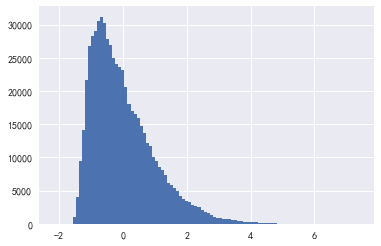

In [27]:
# 去极值
factor_filt = factor.groupby(level='date', group_keys=False).apply(ops.adjboxplot)
# 标准化
zscore = factor_filt.groupby(level='date', group_keys=False).apply(lambda x: (x - x.mean()) / x.std())

print(zscore.describe())
print('\nSkewness = {:.2f} \nKurtosis = {:.2f}'.format(zscore.skew(), zscore.kurt()))

zscore.hist(bins=100)

count    1823.000000
mean        0.004804
std         0.005823
min         0.000000
25%         0.000000
50%         0.003067
75%         0.006231
max         0.036913
Name: bp, dtype: float64


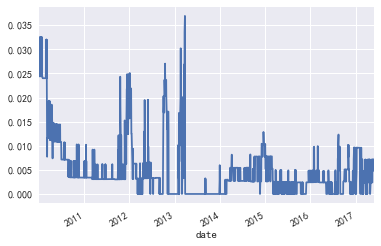

In [28]:
# remove ratio
remove_ratio = (factor.groupby(level='date').count() - zscore.groupby(level='date').count()) / factor.groupby(level='date').count() 
print(remove_ratio.describe())
remove_ratio.plot()

# 数据分析

## 行业分布

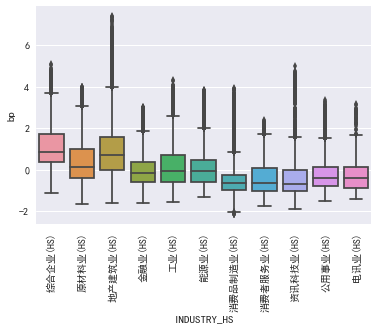

In [31]:
ax = sns.boxplot(x=industry.loc[zscore.index], y=zscore)
for item in ax.get_xticklabels():
    item.set_rotation(90)

## 市值分布

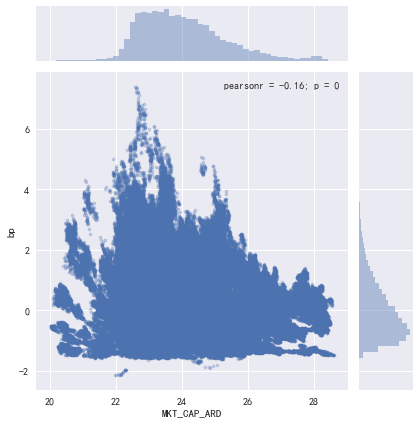

In [33]:
sns.jointplot(y=zscore, x=size, alpha=0.3, s=10)

count    1823.000000
mean       -0.169132
std         0.095427
min        -0.374964
25%        -0.246600
50%        -0.174747
75%        -0.091552
max         0.066357
dtype: float64


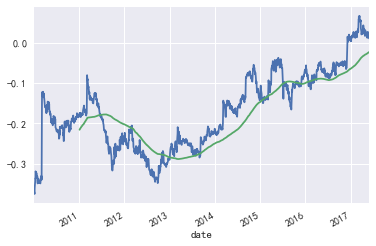

In [34]:
mz_df = pd.concat([zscore, mkt_cap], axis=1)
rank_corr = mz_df.groupby(level='date').apply(lambda x: x['bp'].corr(x['MKT_CAP_ARD'], method='spearman'))
print(rank_corr.describe())
rank_corr.plot()
rank_corr.rolling(252).mean().plot()

bp因子和市值因子长期相关性较小，历史平均值为-17%。从相关系数的时间序列上看，两者相关性从2013年开始逐渐变大，最高可达 6%。<br>因此，虽然两者长期关系不明显，但短期明显的正相关需要注意。

## 收益分析

In [35]:
periods = (1, 5, 10, 20, 40)
quantiles = 10
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(zscore,
                                                                   pricing,
                                                                   quantiles=quantiles,
                                                                   periods=periods,
                                                                   bins=None,
                                                                   groupby=industry)

### 全样本内因子与收益率的关系

In [36]:
mean_return_by_q, std_err_by_q = alphalens.performance.mean_return_by_quantile(factor_data, by_group=False)

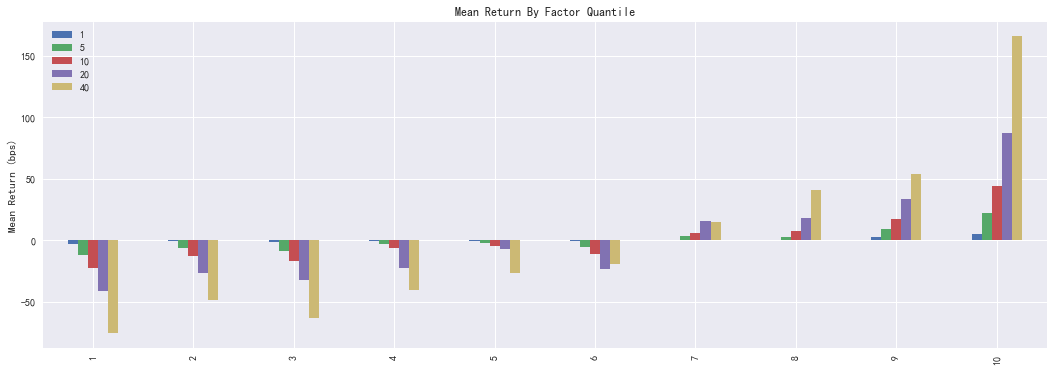

In [37]:
alphalens.plotting.plot_quantile_returns_bar(mean_return_by_q)

作图展示不同分位数组合的日平均超额收益情况，图中的纵轴超额收益的单位为bps(0.0001)，可以看出：

- 这个因子对不同forward窗口的收益率都有一定的区分度；
- 无论哪一个forward窗口，收益率最大组都是第10组
- 随着forward窗口的增加（1-40），各组平均收益也增加

In [38]:
mean_return_by_q_daily, std_err = alphalens.performance.mean_return_by_quantile(
                                        factor_data,
                                        by_date=True,
                                        by_group=False
                                        )

mean_return_by_q_daily.head()

1         5         10        20        40
factor_quantile date                                                        
1               2010-01-04  0.000350 -0.014289 -0.012170 -0.027385 -0.017258
                2010-01-05 -0.008498 -0.022647 -0.013224 -0.025081 -0.019180
                2010-01-06 -0.006962 -0.008777 -0.011339 -0.032180 -0.018914
                2010-01-07  0.000228 -0.004609 -0.012327 -0.030682 -0.006128
                2010-01-08 -0.003825  0.004546 -0.017160 -0.023123 -0.002949

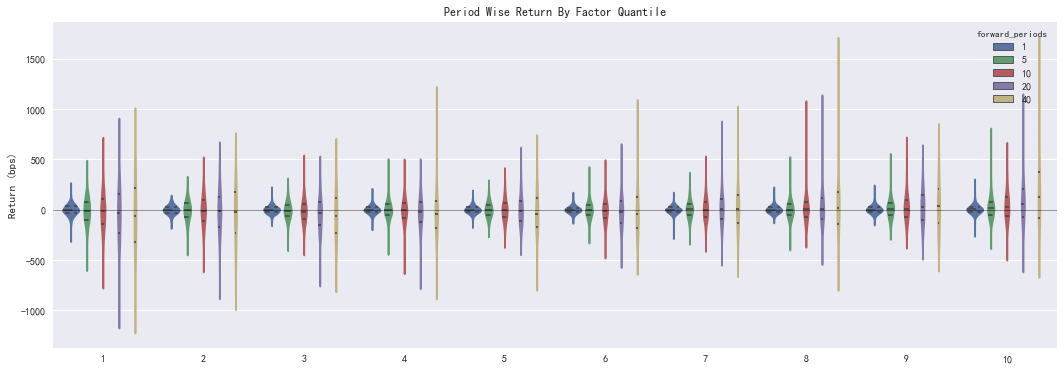

In [39]:
alphalens.plotting.plot_quantile_returns_violin(mean_return_by_q_daily)

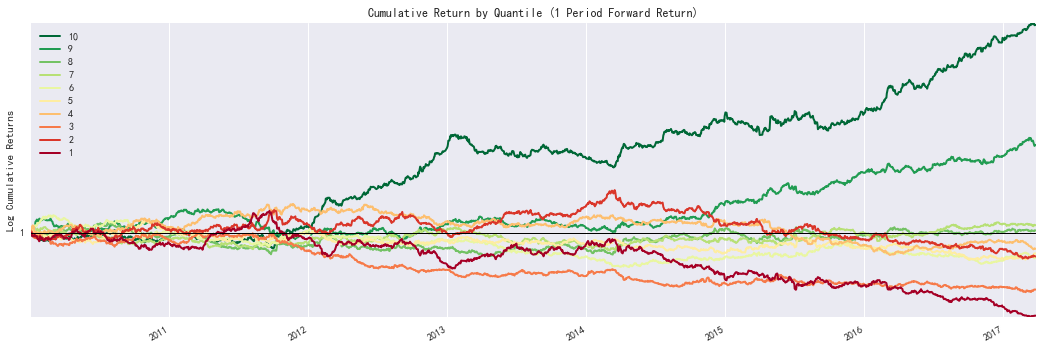

In [40]:
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q_daily)

**该因子对股票有一定的区分度，1、9、10组区分明显；其余分组区分并不明显**

### 进一步行业分析

In [50]:
mean_return_quantile_sector, mean_return_quantile_sector_err = alphalens.performance.mean_return_by_quantile(factor_data, by_group=True)

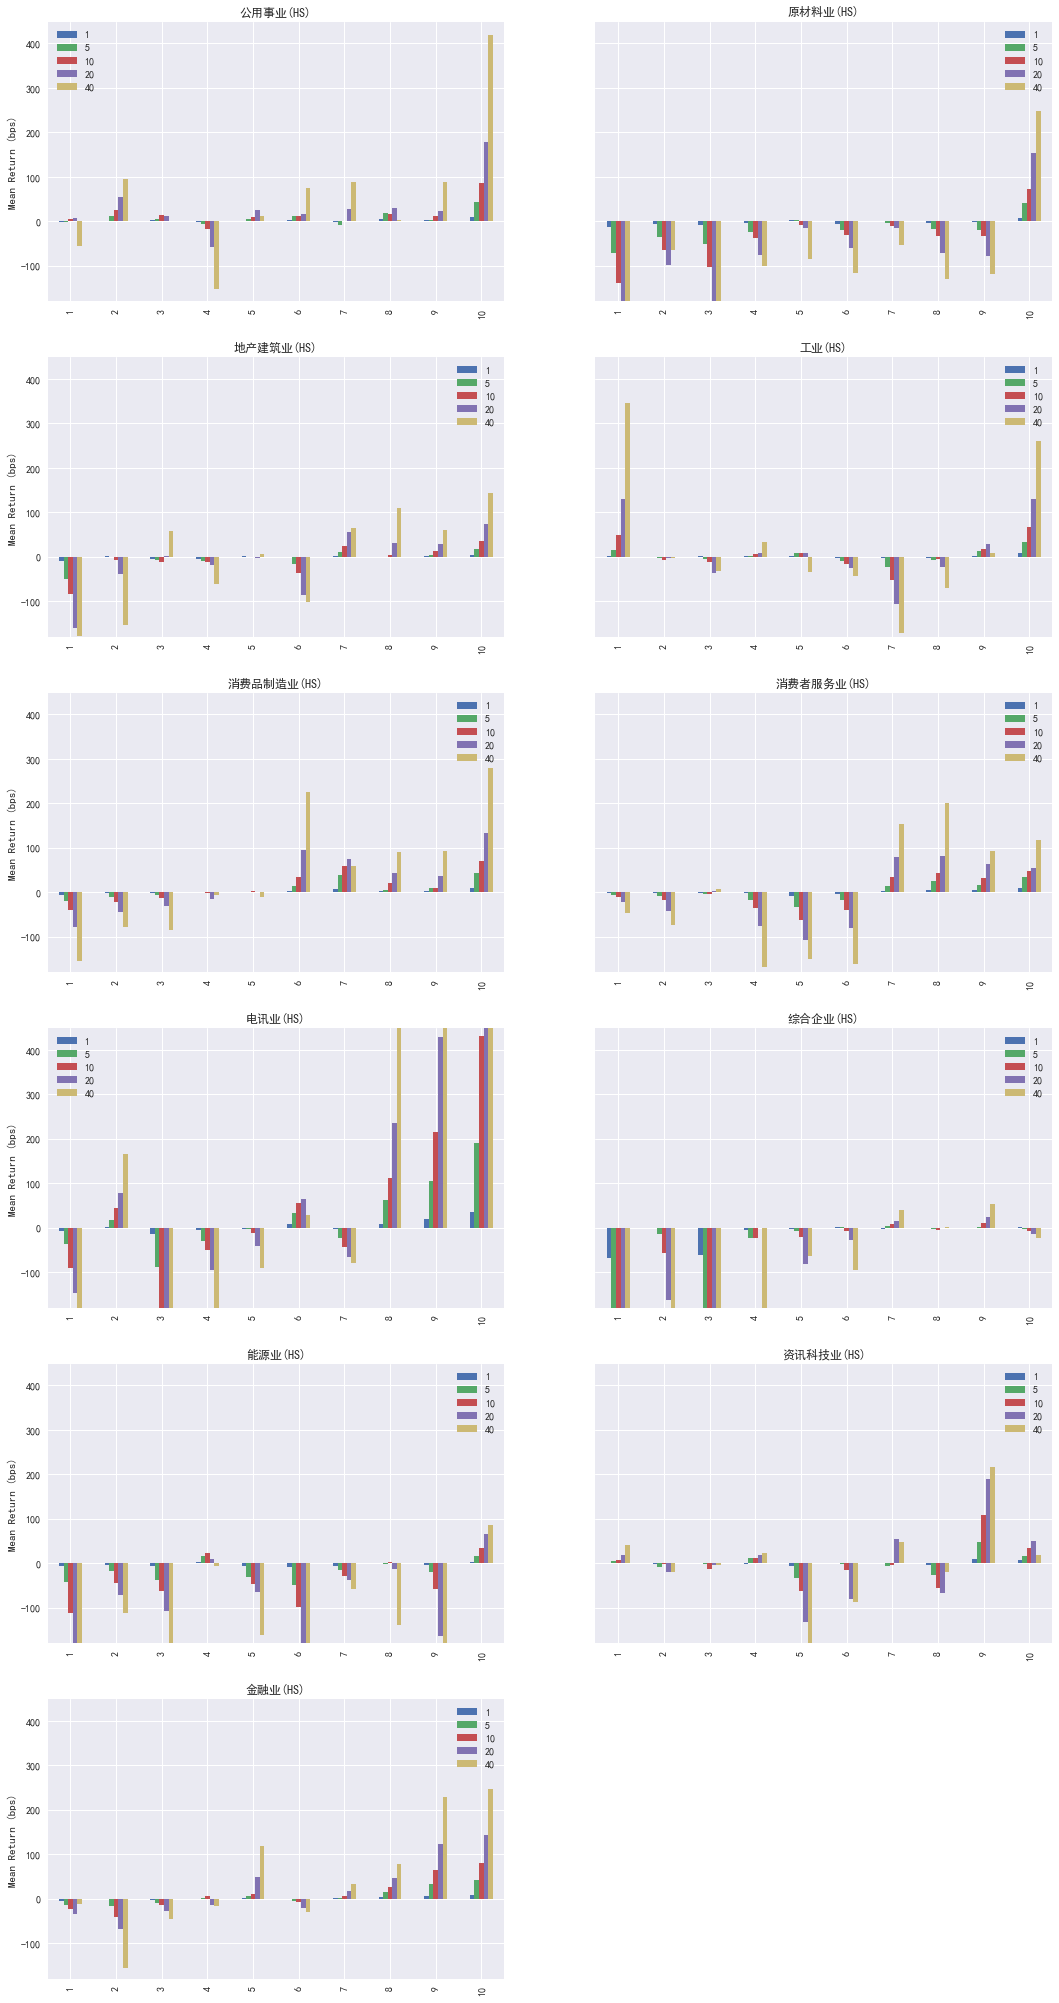

In [51]:
alphalens.plotting.plot_quantile_returns_bar(mean_return_quantile_sector, by_group=True);

**bp因子在不同行业收益表现差异较大，和前面的分析一致。**

## IC 分析

In [42]:
ic = alphalens.performance.factor_information_coefficient(factor_data)

**SUMMARY**

In [43]:
alphalens.plotting.plot_information_table(ic)

Information Analysis


,1,5,10,20,40
IC Mean,0.008,0.014,0.022,0.035,0.046
IC Std.,0.107,0.131,0.142,0.149,0.152
t-stat(IC),3.275,4.384,6.458,9.875,12.792
p-value(IC),0.001,0.000,0.000,0.000,0.000
IC Skew,0.149,0.151,0.178,0.192,0.246
IC Kurtosis,-0.215,-0.282,-0.416,-0.511,-0.680
Ann. IR,1.231,1.648,2.428,3.712,4.809


### IC时间序列

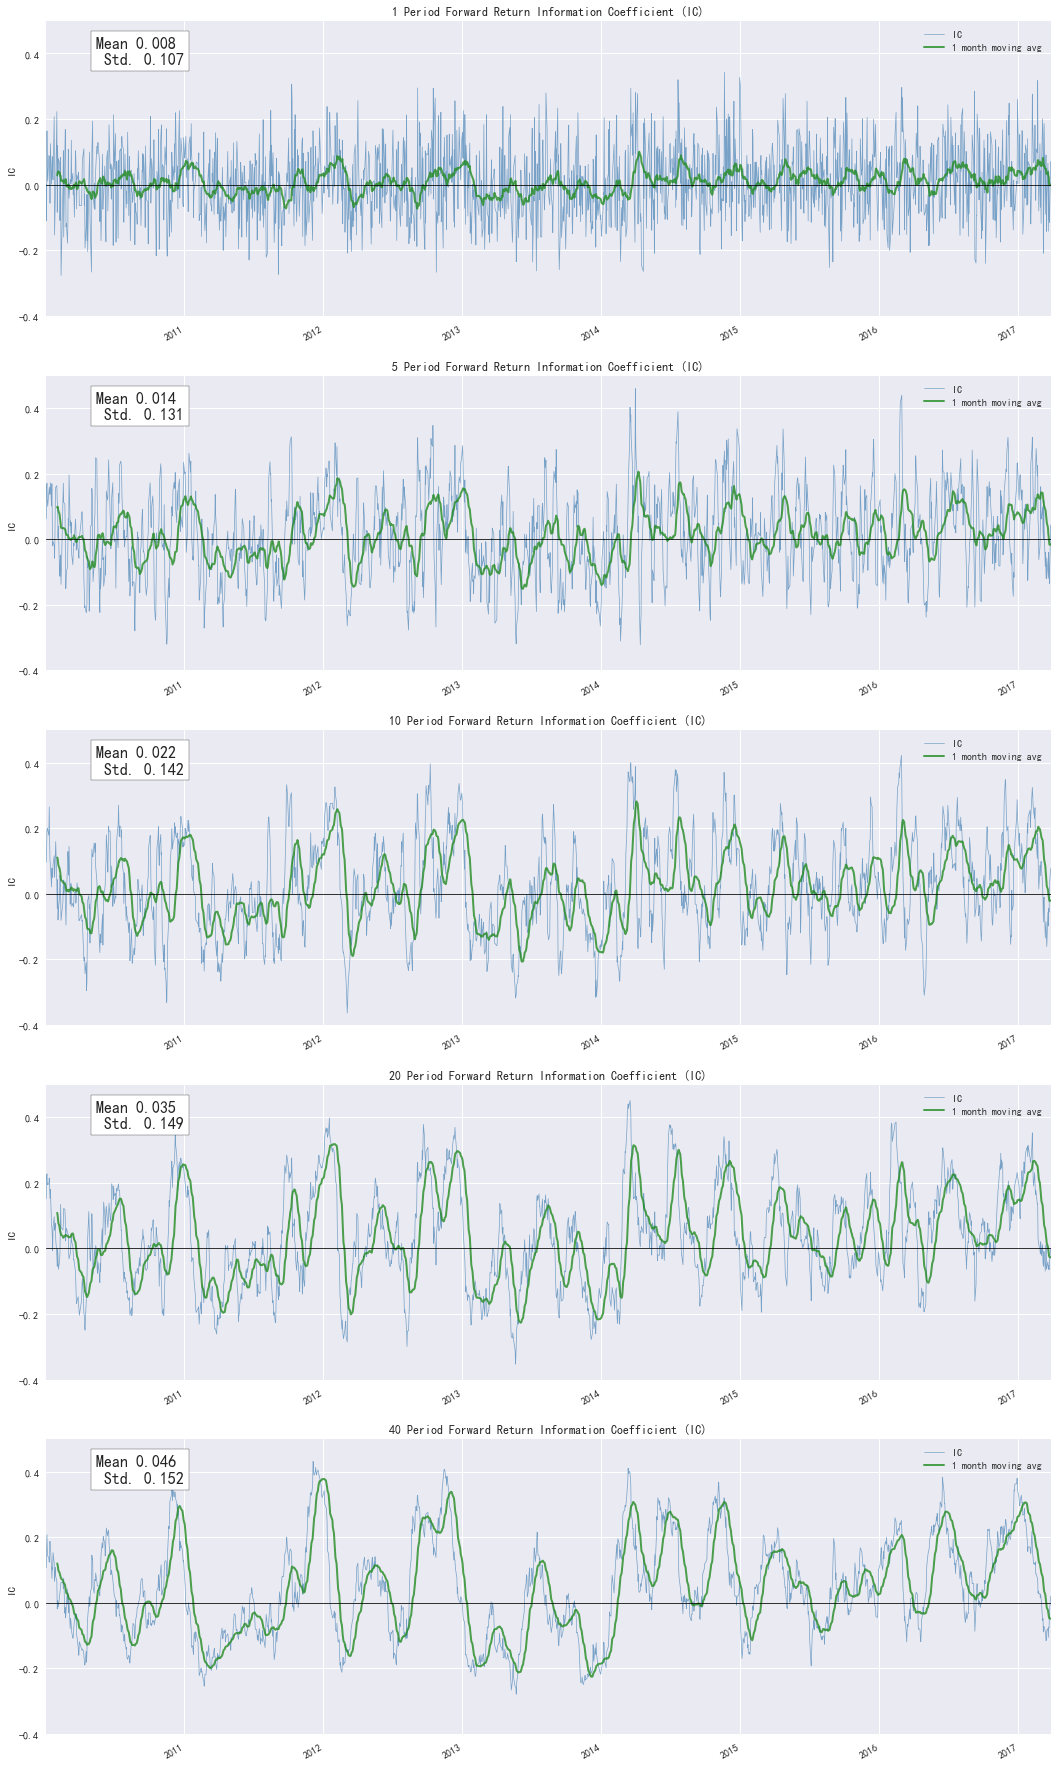

In [48]:
alphalens.plotting.plot_ic_ts(ic);

对于不同的调仓周期，从因子信息系数的时间序列图可以看出：

- 在所有forward窗口下，IC随时间而变化
- 所有Forward 窗口 IC均值都大于0，并随着窗口的增大而增大

### IC序列分布

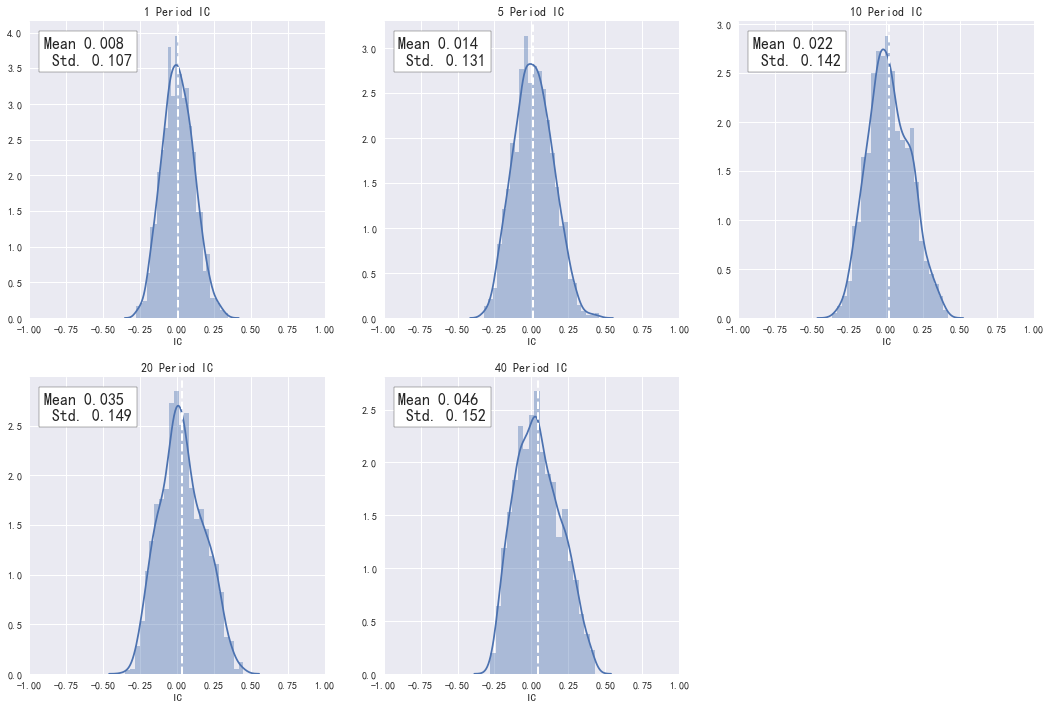

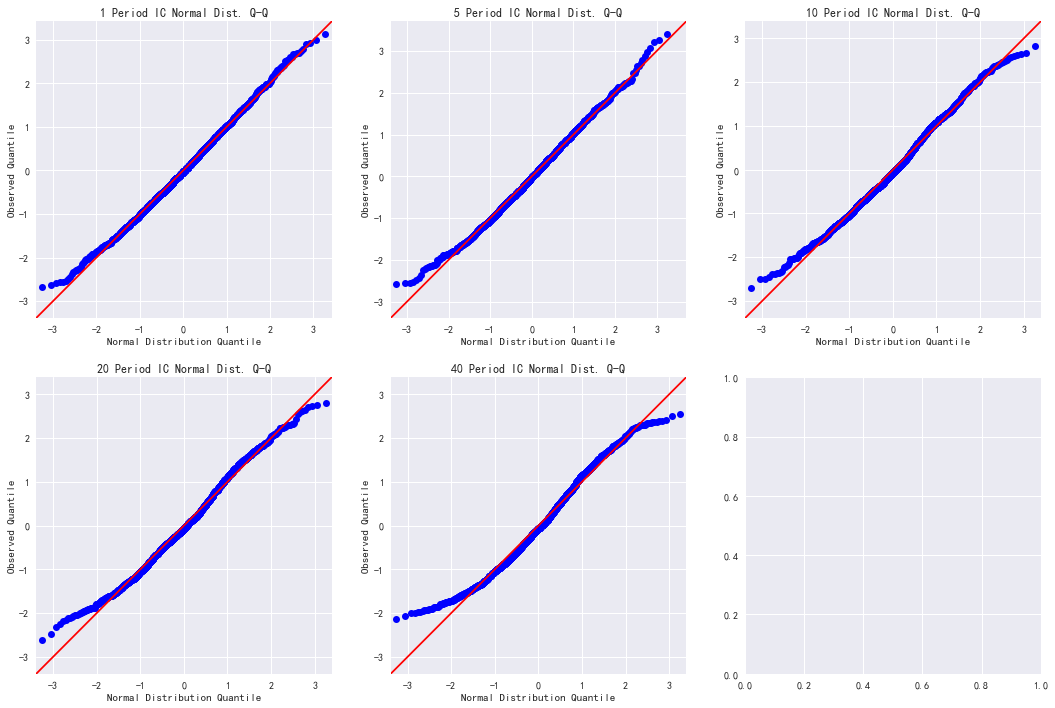

In [47]:
alphalens.plotting.plot_ic_hist(ic);
alphalens.plotting.plot_ic_qq(ic);

### IC衰减

In [52]:
max_period = 64
leads = range(1, max_period)
lead_rtn = pd.concat({i: factor_data[20].groupby(level='asset').shift(-i) for i in leads}, axis=1)

In [53]:
#去掉全部为nan收益的日期
empty_date = lead_rtn.groupby(level = 'date').apply(lambda x:x[max_period - 1].notnull().sum().sum()==0)
whole_date = [idx for idx, jg in empty_date.iterkv() if jg]
concat_rtn = pd.concat([factor_data['factor'], lead_rtn], axis=1)
concat_rtn = concat_rtn.drop(whole_date)

In [54]:
lag_ic = alphalens.performance.factor_information_coefficient(concat_rtn)

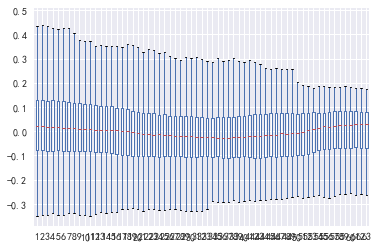

In [55]:
lag_ic.plot.box()

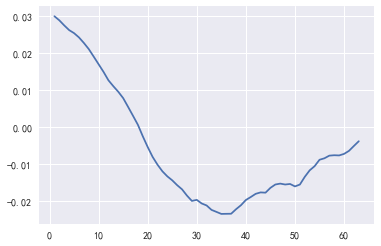

In [56]:
#衰减图
lag_ic_mean = lag_ic.mean()
plt.plot(lag_ic_mean.index, lag_ic_mean.values)

**由上图可以看出， IC值在0到30之间有明显的衰减趋势**

In [58]:
#半衰期
x = pd.Series(leads)
a, b = ic_decay_fit(x, lag_ic_mean)
halflife = int(1 / b * pd.np.log(0.5))
print('='*60)
print('\tBP 因子的半衰期为： %d' % halflife)
print('='*60)

	BP 因子的半衰期为： 116


### 进一步行业分析

In [59]:
ic_by_sector = alphalens.performance.mean_information_coefficient(factor_data, by_group=True)

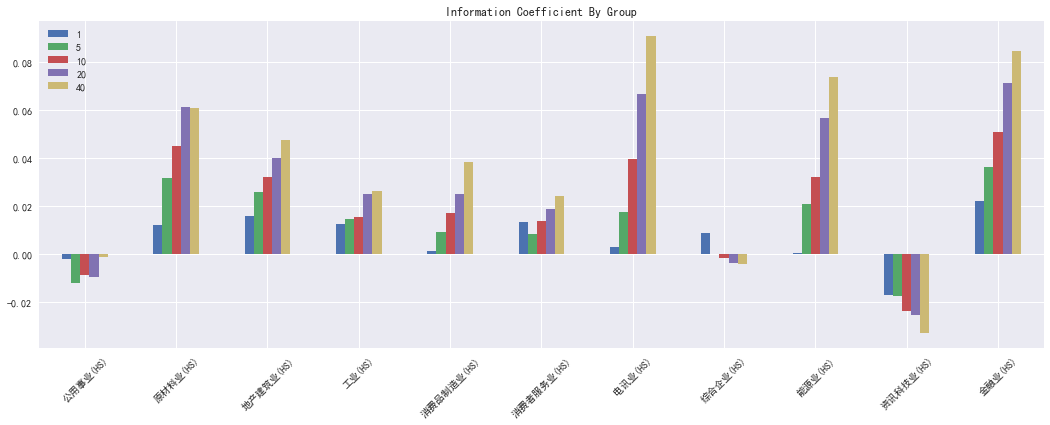

In [61]:
alphalens.plotting.plot_ic_by_group(ic_by_sector);

## 换手率分析

Turnover Analysis


,1,5,10,20,40
Quantile 1 Mean Turnover,0.033,0.065,0.091,0.132,0.196
Quantile 2 Mean Turnover,0.063,0.127,0.176,0.248,0.344
Quantile 3 Mean Turnover,0.082,0.166,0.228,0.317,0.433
Quantile 4 Mean Turnover,0.092,0.188,0.259,0.360,0.488
Quantile 5 Mean Turnover,0.096,0.198,0.272,0.373,0.497
Quantile 6 Mean Turnover,0.100,0.207,0.286,0.387,0.515
Quantile 7 Mean Turnover,0.095,0.196,0.270,0.370,0.489
Quantile 8 Mean Turnover,0.084,0.171,0.236,0.325,0.435
Quantile 9 Mean Turnover,0.072,0.145,0.199,0.276,0.378
Quantile 10 Mean Turnover,0.037,0.072,0.099,0.139,0.200


,1,5,10,20,40
Mean Factor Rank Autocorrelation,0.999,0.997,0.994,0.988,0.978


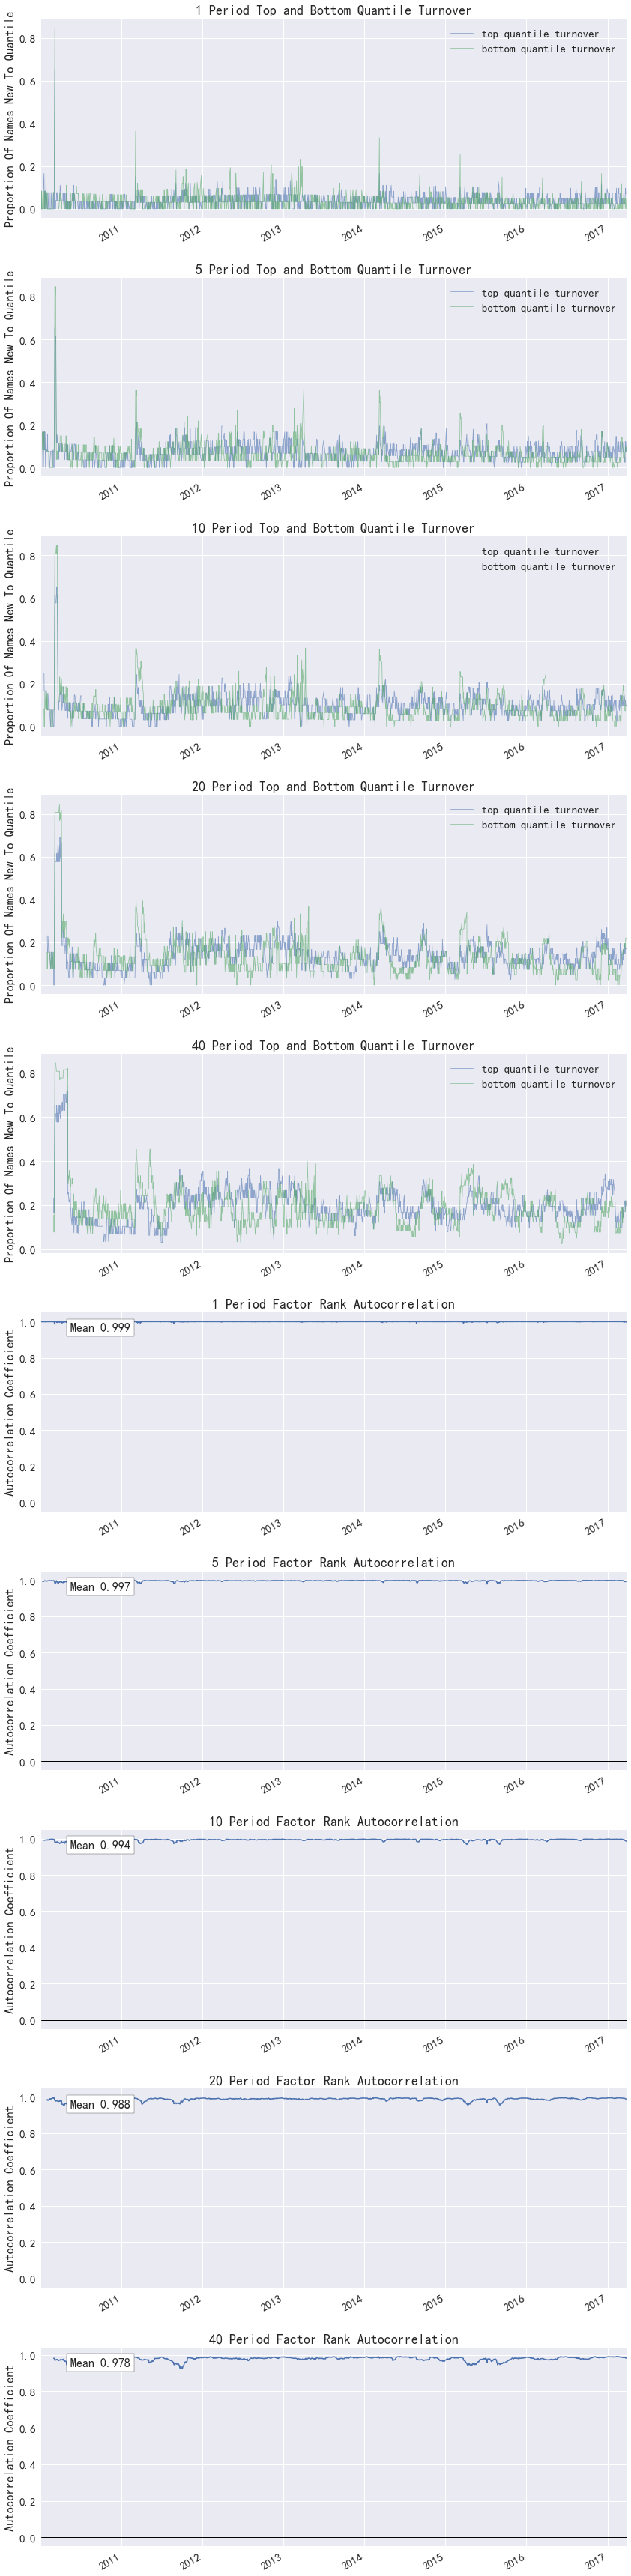

In [64]:
alphalens.tears.create_turnover_tear_sheet(factor_data);

bp因子换手率不高，尤其是在持仓时间较短的情况下。<br>
随着持仓时间拉长，换手率逐渐增高，20日换手率top组和bottom组长期维持在10%~20。<br>
另外，该因子自相关性较强，20日滞后自相关系数高达98.8%，也从侧面说明该因子换手率不会太高。

## 简单因子组合

In [65]:
pf_ols = simple_factor_portfolio(zscore, pricing)
pf_wls = simple_factor_portfolio(zscore, pricing, size)
factor_return_ols = {date: mod.beta[0] for date, mod in pf_ols.items()}
factor_return_wls = {date: mod.beta[0] for date, mod in pf_wls.items()}
factor_return = pd.DataFrame({'simple_portfolio_ols': pd.Series(factor_return_ols),
                              'simple_portfolio_wls': pd.Series(factor_return_wls)})

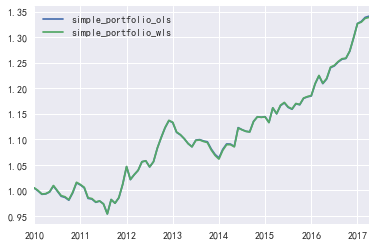

In [70]:
((factor_return + 1).cumprod()-1)

In [83]:
ln_x_mon = pd.np.log((factor_return + 1).cumprod().iloc[-1:])/len(factor_return)
print('\n平均年化收益率:\n')
pd.np.exp(ln_x_mon*12)-1


平均年化收益率:



,simple_portfolio_ols,simple_portfolio_wls
2017-04-30,0.04089,0.040653


In [88]:
print('\n平均年化波动率:\n')

factor_return.std(axis = 0)*pd.np.sqrt(12)


平均年化波动率:



simple_portfolio_ols    0.042442
simple_portfolio_wls    0.042601
dtype: float64

## 中性化

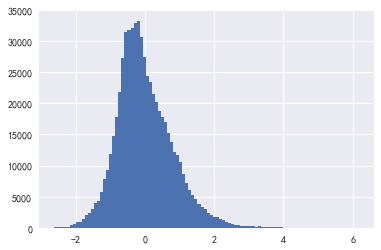

In [89]:
neutral_factor = compute_neutral_factor(zscore, size, industry)
neutral_factor.hist(bins=100)

In [90]:
neutral_factor_data = alphalens.utils.get_clean_factor_and_forward_returns(neutral_factor, pricing, periods=periods, groupby=industry)
neutral_ic = alphalens.performance.factor_information_coefficient(neutral_factor_data)

In [91]:
alphalens.plotting.plot_information_table(neutral_ic)

Information Analysis


,1,5,10,20,40
IC Mean,0.012,0.018,0.024,0.033,0.040
IC Std.,0.082,0.095,0.100,0.104,0.105
t-stat(IC),6.404,8.173,10.093,13.536,16.250
p-value(IC),0.000,0.000,0.000,0.000,0.000
IC Skew,0.077,0.047,0.035,-0.043,0.005
IC Kurtosis,-0.330,-0.150,-0.332,-0.460,-0.414
Ann. IR,2.407,3.073,3.794,5.089,6.109


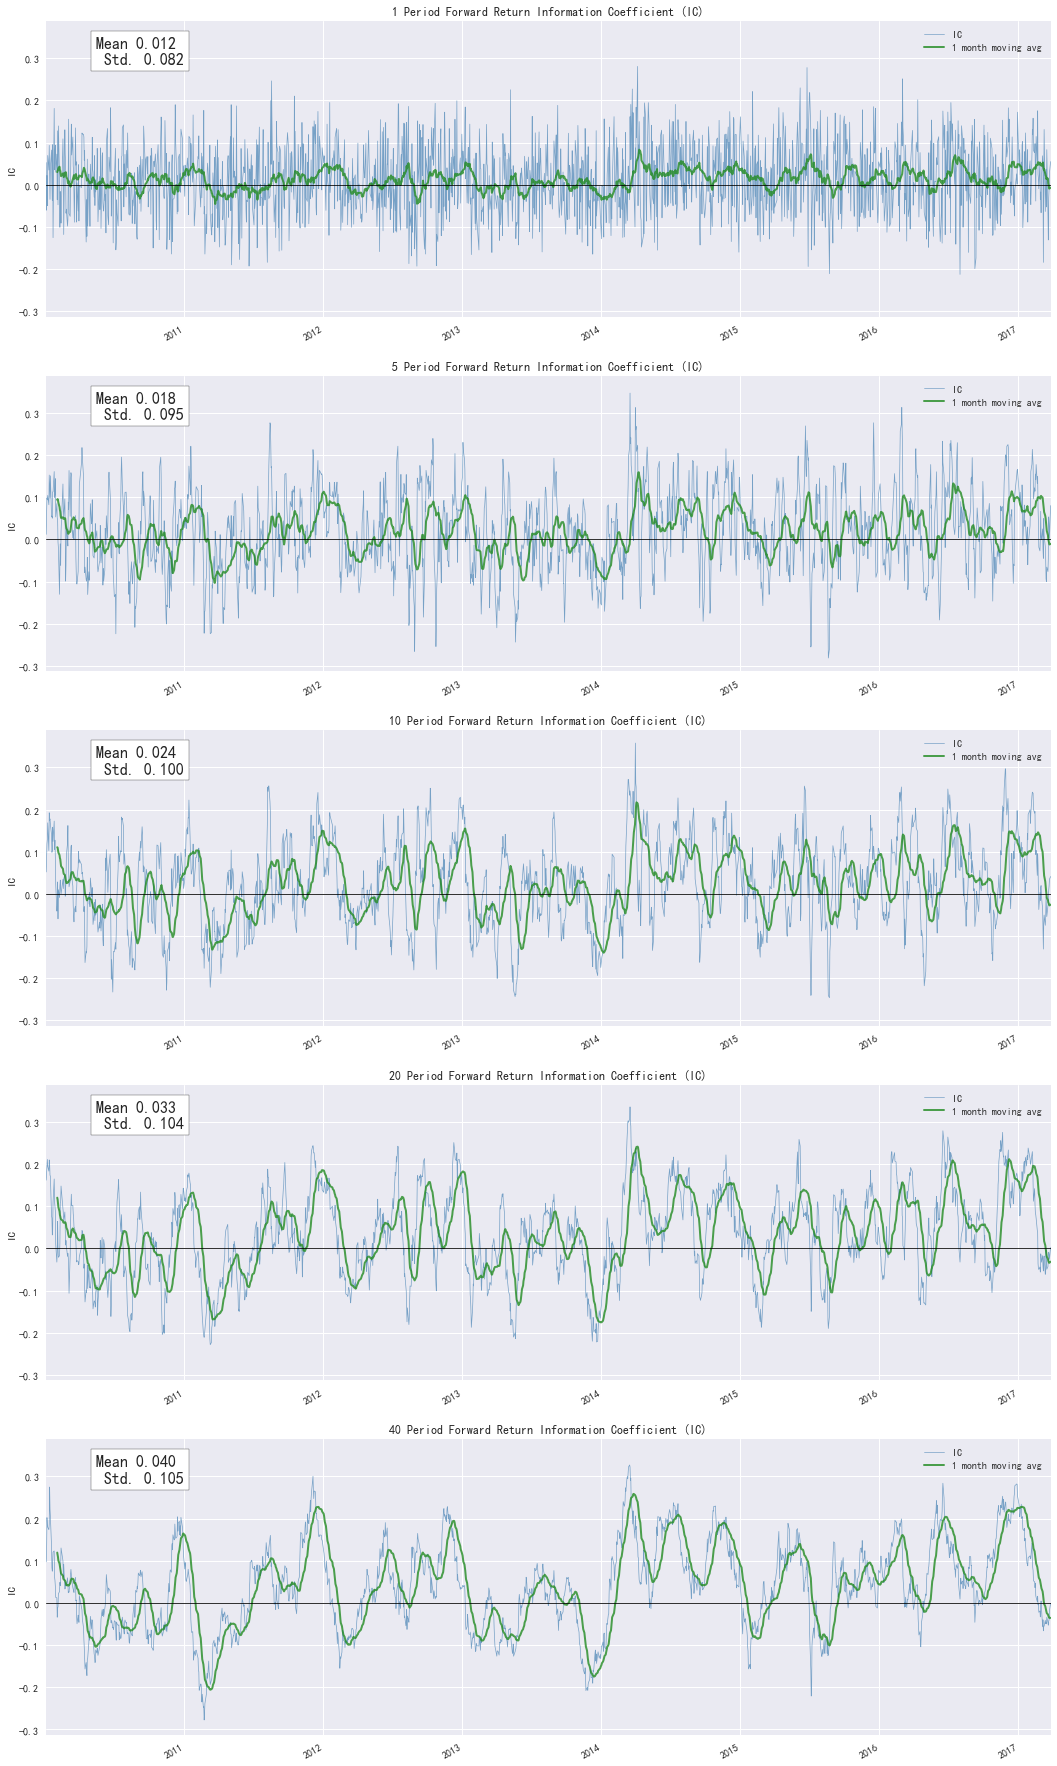

In [93]:
alphalens.plotting.plot_ic_ts(neutral_ic);

中性化之后，均值的绝对值比中性化之前更大, 波动率也比之前更小。